# 데이터 로드

In [22]:
from Tsai_data_preprocessing import load_tsai_data_and_create_dls

save_path = "./src/preprocessed_tsai_data.npz"
dls = load_tsai_data_and_create_dls(save_path)

DataLoaders created from ./src/preprocessed_tsai_data.npz


In [30]:
# 학습용 DataLoader의 첫 번째 배치 확인
x_train, y_train = dls.train.one_batch()
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

# 검증용 DataLoader의 첫 번째 배치 확인
x_valid, y_valid = dls.valid.one_batch()
print(f"x_valid shape: {x_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")


x_train shape: torch.Size([512, 62, 5])
y_train shape: torch.Size([512])
x_valid shape: torch.Size([1024, 62, 5])
y_valid shape: torch.Size([1024])


In [1]:
from tsai.all import *
import warnings

computer_setup()

c:\Users\iinmv\anaconda3\envs\nuclear_bootcamp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


os              : Windows-11-10.0.26100-SP0
python          : 3.12.8
tsai            : 0.3.9
fastai          : 2.7.18
fastcore        : 1.7.20
torch           : 2.2.2
device          : 1 gpu (['NVIDIA GeForce RTX 4060 Laptop GPU'])
cpu cores       : 6
threads per cpu : 2
RAM             : 15.29 GB
GPU memory      : [8.0] GB


In [24]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)

In [25]:
for xb, yb in dls.train:
    print(torch.isnan(xb).any(), torch.isnan(yb).any())
    break

TSTensor([False], device=cuda:0, dtype=torch.bool) TensorCategory(False, device='cuda:0')


In [24]:
import pandas as pd
import time
from tsai.all import *
from IPython.display import clear_output

# --------------------------------------------------
# archs: 여러 가지 아키텍처 후보
# --------------------------------------------------
archs = [
    (ResNet, {}),
    (RNNPlus, {'n_layers':3, 'bidirectional': True}),
    (LSTMPlus,{'n_layers':3, 'bidirectional': True}),
    (GRUPlus, {'n_layers':3, 'bidirectional': True}),
    (RNNPlus, {'n_layers':4, 'bidirectional': True}),
    (RNNPlus, {'n_layers':4, 'bidirectional': False}),
    (LSTM,    {'n_layers':3, 'bidirectional': False}),
    (RNN,     {'n_layers':3, 'bidirectional': True}),
    (LSTM,    {'n_layers':3, 'bidirectional': True}),
    (GRU,     {'n_layers':3, 'bidirectional': True}),
    (InceptionTime, {}),
    (XceptionTime,  {}),
    (TCN, {}),
    (LSTM_FCN, {}),
    (TST, {}),
    (FCN, {}),
    (xresnet1d34, {}),
    (xresnet1d50_deeper, {}),
]

results = pd.DataFrame(columns=['arch', 'hyperparams', 'total_params', 'train_loss', 'valid_loss', 'accuracy', 'time'])

# --------------------------------------------------
# 모델 루프
# --------------------------------------------------
for i, (arch, k) in enumerate(archs):
    # k에서 'seq_len' 제거
    if 'seq_len' in k and 'RNN' not in arch.__name__:
        k = {param:val for param,val in k.items() if param != 'seq_len'}
        
    # 모델 생성
    model = create_model(arch, dls=dls, **k)
    model.apply(initialize_weights)
    
    # Learner
    learn = Learner(dls, model, metrics=accuracy)
    
    print(f"\n=== {arch.__name__} with {k} ===")
    start = time.time()
    learn.fit_one_cycle(20, 1e-3)  # 에폭 20, lr=1e-3 예시
    elapsed = time.time() - start
    
    # 기록
    vals = learn.recorder.values[-1]  # [train_loss, valid_loss, accuracy, ...]
    results.loc[i] = [
        arch.__name__,
        k,
        count_parameters(model),
        vals[0],   # train_loss
        vals[1],   # valid_loss
        vals[2],   # accuracy
        int(elapsed)
    ]
    
    # 정렬 & 출력
    results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)
    clear_output()
    display(results)


,arch,hyperparams,total_params,train_loss,valid_loss,accuracy,time
0,RNNPlus,"{'n_layers': 4, 'bidirectional': False}",77505,0.072447,0.075973,0.976097,207
1,RNNPlus,"{'n_layers': 3, 'bidirectional': True}",154605,0.069426,0.076092,0.976046,267
2,LSTMPlus,"{'n_layers': 3, 'bidirectional': True}",615405,0.072893,0.075546,0.975944,262
3,RNNPlus,"{'n_layers': 4, 'bidirectional': True}",215005,0.068856,0.077161,0.974054,315
4,GRUPlus,"{'n_layers': 3, 'bidirectional': True}",461805,0.072828,0.077879,0.972930,283
5,ResNet,{},510085,0.074088,0.081716,0.972113,424



=== LSTM with {'n_layers': 3, 'bidirectional': False} ===


epoch,train_loss,valid_loss,accuracy,time
0,0.125348,0.112333,0.961949,00:09
1,0.102285,0.099505,0.964809,00:08
2,0.098578,0.093858,0.965831,00:08
3,0.103409,0.089737,0.968436,00:08
4,0.092386,0.086784,0.969457,00:09
5,0.094904,0.083908,0.969661,00:08
6,0.087210,0.086242,0.970172,00:08
7,0.084132,0.083768,0.970274,00:08
8,0.085153,0.095225,0.970172,00:08
9,0.084434,0.087201,0.970428,00:09


KeyboardInterrupt: 

# RNNPlus 학습

In [26]:
arch = RNNPlus
k = {
    # 'c_in': dls.vars,  # 제거: build_ts_model이 이미 처리
    # 'c_out': dls.c,    # 제거: build_ts_model이 이미 처리
    'hidden_size': [200, 100],  # 은닉 상태 크기
    'n_layers': 3,     # 레이어 수
    'rnn_dropout': 0.1,  # RNN 드롭아웃 비율
    'bidirectional': True,  # 양방향 설정
    'fc_dropout': 0.2,  # 완전 연결층 드롭아웃 비율
    'last_step': True,  # 마지막 스텝만 출력
}

# c_in, c_out은 별도로 지정
model = build_ts_model(RNNPlus, arch_config=k, dls=dls)


# Optimal learnig rate

SuggestedLRs(valley=0.0002290867705596611)

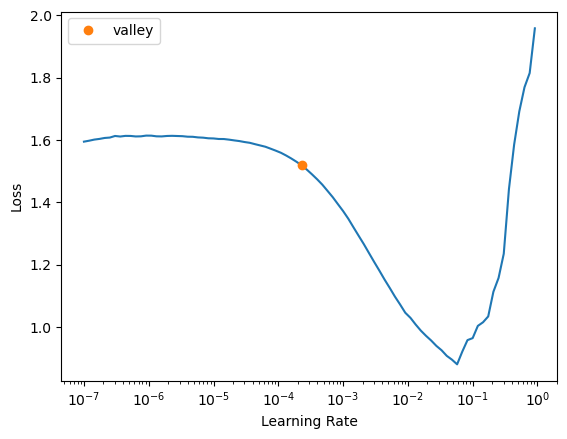

In [27]:
learn = ts_learner(dls, arch=model, metrics=accuracy)
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.345028,0.293210,0.939067,00:12
1,0.142867,0.128767,0.965320,00:11
2,0.122691,0.108322,0.966239,00:11
3,0.115849,0.100929,0.966290,00:11
4,0.102275,0.098243,0.966137,00:10
5,0.109655,0.097688,0.967312,00:10
6,0.106728,0.093707,0.968231,00:11
7,0.102818,0.091704,0.967669,00:10
8,0.095035,0.090300,0.966341,00:10
9,0.092002,0.090024,0.968027,00:11


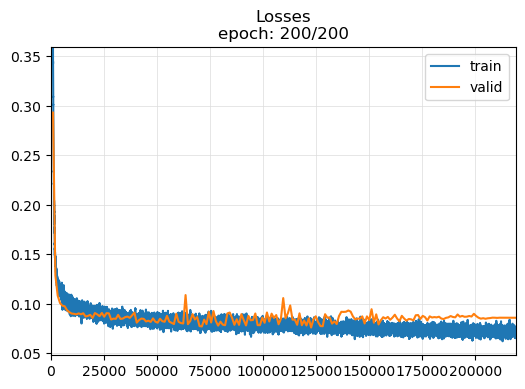

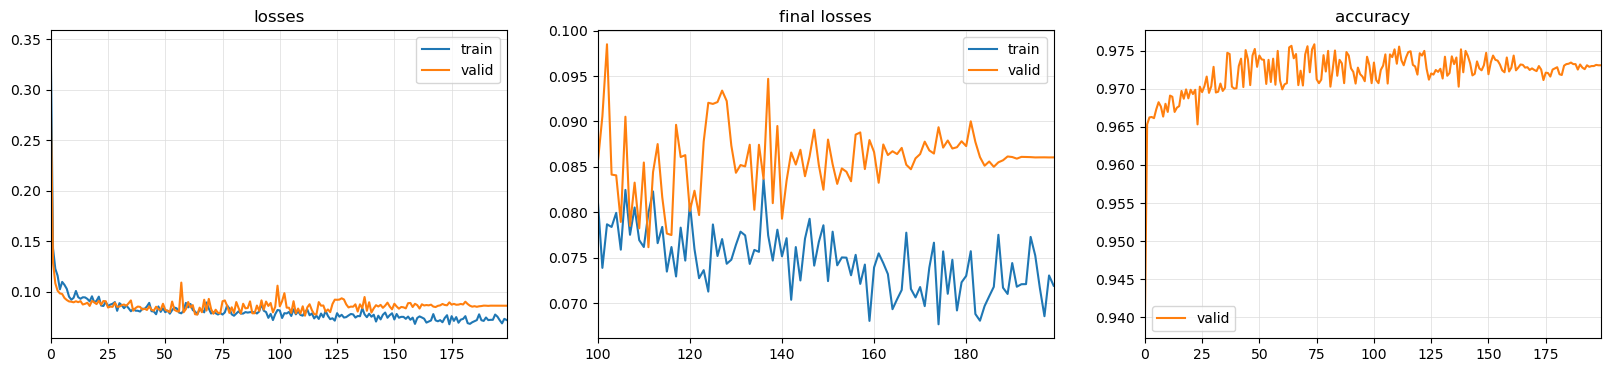

In [45]:
learn = Learner(dls, model, metrics=accuracy)
start = time.time()
learn.fit_one_cycle(n_epoch=200, lr_max=0.0002, cbs=ShowGraph())
#모델 저장
learn.export('./models/RNNPlus_model.pkl')

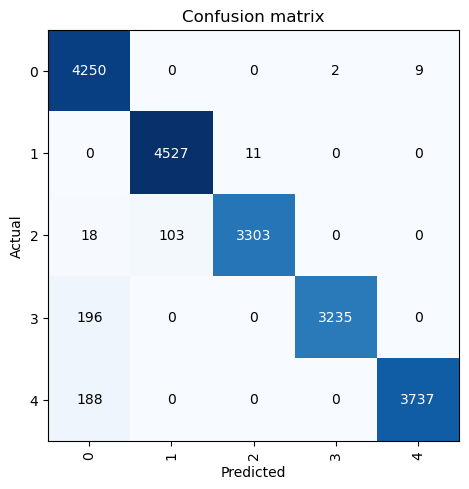

In [46]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [47]:
interp.most_confused(min_val=3)

[(3, 0, 196), (4, 0, 188), (2, 1, 103), (2, 0, 18), (1, 2, 11), (0, 4, 9)]

In [39]:
# 이미 npz에 (N, 62, 5) 형태로 저장되어 있음
data = np.load('./src/preprocessed_tsai_data.npz')
test_X = data['test_X']  # shape: (N, 62, 5)
test_y = data['test_y']  # shape: (N,)

learn.get_X_preds(test_X, y=test_y, with_decoded=True)

(tensor([[9.9963e-01, 4.5256e-06, 2.6894e-05, 1.4239e-04, 1.9355e-04],
         [9.9963e-01, 4.5002e-06, 2.6797e-05, 1.4223e-04, 1.9319e-04],
         [9.9963e-01, 4.4860e-06, 2.6750e-05, 1.4210e-04, 1.9290e-04],
         ...,
         [1.4397e-04, 5.4641e-06, 8.4596e-06, 8.9171e-05, 9.9975e-01],
         [1.4920e-04, 5.5407e-06, 8.7296e-06, 9.0280e-05, 9.9975e-01],
         [1.5536e-04, 5.6212e-06, 9.0482e-06, 9.1497e-05, 9.9974e-01]]),
 tensor([0, 0, 0,  ..., 4, 4, 4]),
 '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [44]:
from tsai.all import load_learner
from sklearn.metrics import accuracy_score

preds, targets = learn.get_X_preds(test_X, y=test_y, with_decoded=False)


In [46]:
acc = accuracy_score(targets, preds)
print("Accuracy:", acc)

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

In [16]:
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sktime
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import seaborn as sns
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.sarimax import SARIMAX
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.compose import (
    EnsembleForecaster,
    MultiplexForecaster,
    TransformedTargetForecaster,
    make_reduction,
)
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.transformations.panel.rocket import MiniRocket
from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError, MeanSquaredError
from sktime.utils.plotting import plot_series
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sktime.datasets import load_from_tsfile
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [35]:
def preprocess_data_with_sliding_window(X, y, segment_size=5, stride=1):
    """
    X, y (넘파이 배열)에서 윈도우 크기 segment_size, stride로 세그먼트화.
    마지막 시점 라벨을 세그먼트 라벨로 사용.
    """
    segments, labels = [], []
    length = len(X)
    for start_idx in range(0, length - segment_size + 1, stride):
        end_idx = start_idx + segment_size
        segment_data = X[start_idx:end_idx]      # (segment_size, n_vars)
        segment_label = y[end_idx - 1]           # 마지막 시점 라벨

        segments.append(segment_data)
        labels.append(segment_label)

    segments = np.array(segments)
    labels = np.array(labels)
    return segments, labels


In [37]:
import numpy as np
from tsai.all import load_learner
from sklearn.metrics import accuracy_score

# (1) .npz 파일 로드
data = np.load("./src/preprocessed_tsai_data.npz")

test_segments, test_labels = preprocess_data_with_sliding_window(
    data['test_X'],  # 원본 시계열
    data['test_y'],
    segment_size=5, 
    stride=1
)

test_segments = test_segments.transpose(0, 2, 1, 3)
# => (41339, 62, 5, 5)

test_segments = test_segments.reshape(
    test_segments.shape[0],  # 배치=41339
    62,                      # 채널
    5 * 5                    # 시퀀스 길이=25
)
# => (41339, 62, 25)


print("test_segments.shape:", test_segments.shape)  # (41343, 62, 5)
print("test_labels.shape:  ", test_labels.shape)    # (41343,)

# (2) 학습된 모델 로드
learn = load_learner("./models/RNNPlus_model.pkl")


probas, targets, preds = learn.get_X_preds(test_segments, y=test_labels, with_decoded=True)

# (4) 정확도 계산
acc = accuracy_score(targets, preds)
print(f"Test Accuracy: {acc:.4f}")


test_segments.shape: (41339, 62, 25)
test_labels.shape:   (41339,)


ValueError: Found input variables with inconsistent numbers of samples: [41339, 124017]

In [19]:
import numpy as np

def create_sliding_window(X, y, segment_size=5, stride=1):
    """
    주어진 X, y 시계열 데이터를 segment_size 길이의 슬라이딩 윈도우로 분할합니다.
    각 세그먼트의 라벨은 '세그먼트 내 마지막 시점 라벨'로 설정합니다.
    
    Args:
        X (ndarray): shape = (N, num_features)의 시계열 피처 데이터
        y (ndarray): shape = (N,) 또는 (N, 1) 형태의 라벨
        segment_size (int): 윈도우 크기
        stride (int): 윈도우 이동 간격

    Returns:
        segments (ndarray): shape = (M, segment_size, num_features)
        labels   (ndarray): shape = (M,)
    """
    # y가 (N,) 형태라고 가정
    N = len(X)
    segments, labels = [], []

    for start_idx in range(0, N - segment_size + 1, stride):
        end_idx = start_idx + segment_size
        segment_data = X[start_idx:end_idx]      # (segment_size, num_features)
        segment_label = y[end_idx - 1]           # 세그먼트 마지막 시점의 라벨

        segments.append(segment_data)
        labels.append(segment_label)

    # 파이썬 리스트를 넘파이 배열로 변환
    segments = np.array(segments)
    labels   = np.array(labels)

    return segments, labels


In [21]:
import numpy as np
from tsai.all import load_learner
from sklearn.metrics import accuracy_score


# (1) .npz 파일 로드
data = np.load("./src/preprocessed_tsai_data.npz")
test_X = data['test_X']  # shape = (N, num_features)
test_y = data['test_y']  # shape = (N,)

# (2) 슬라이딩 윈도우로 세그먼트/라벨 만들기
segment_size = 5
stride = 1
test_segments, test_labels = create_sliding_window(
    test_X, test_y, segment_size=segment_size, stride=stride
)

print("test_segments shape:", test_segments.shape)
print("test_labels shape:  ", test_labels.shape)

# (3) 학습된 모델 로드
learn = load_learner("./models/RNNPlus_model.pkl")
# (가정) test_segments.shape = (41339, 5, 62, 5)

# 1) 축 순서 바꾸기
test_segments = test_segments.transpose(0, 2, 1, 3)
# 이제 shape = (41339, 62, 5, 5)

# 2) 뒤의 두 차원(5, 5)을 하나로 합쳐 시퀀스 길이=25
test_segments = test_segments.reshape(test_segments.shape[0], 62, 5*5)
# 이제 shape = (41339, 62, 25)

# (4) 예측 수행
probas, targets, preds = learn.get_X_preds(test_segments, y=test_labels, with_decoded=True)

# (5) 정확도 계산
acc = accuracy_score(targets, preds)
print(f"Test Accuracy: {acc:.4f}")


test_segments shape: (41339, 5, 62, 5)
test_labels shape:   (41339,)


ValueError: Found input variables with inconsistent numbers of samples: [41339, 124017]